# Kevin Ferdinand 0358519 Capstone Code


## Import Modules and Install PySpark

In [1]:
!pip list

Package                 Version
----------------------- --------
absl-py                 1.3.0
aiohttp                 3.8.3
aiosignal               1.2.0
altair                  4.1.0
anyio                   3.5.0
appdirs                 1.4.4
argon2-cffi             21.3.0
argon2-cffi-bindings    21.2.0
asttokens               2.0.5
astunparse              1.6.3
async-timeout           4.0.2
attrs                   22.1.0
autovizwidget           0.20.0
Babel                   2.11.0
backcall                0.2.0
beautifulsoup4          4.12.2
bleach                  4.1.0
blinker                 1.4
Bottleneck              1.3.5
brotlipy                0.7.0
cachetools              4.2.2
certifi                 2023.5.7
cffi                    1.15.1
charset-normalizer      2.0.4
click                   8.0.4
colorama                0.4.6
comm                    0.1.2
contourpy               1.0.5
cryptography            39.0.1
cycler                  0.11.0
debugpy                 1

In [2]:
!pip install pyspark

In [3]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
#os.environ['HADOOP_HOME'] = 'C:\Program Files\hadoop\hadoop-3.2.1\bin'

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from datetime import datetime

from matplotlib import pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, StringType, FloatType
from pyspark.sql.functions import when, expr
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.tree import GradientBoostedTrees
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pyspark.sql.functions as F
from pyspark.sql.functions import col, explode, array, lit

from pyspark.ml import PipelineModel



In [5]:
from pyspark import SparkConf

conf = SparkConf()

# Get the maximum memory per executor
max_memory = conf.get("spark.executor.memory")

# Get the number of CPU cores per executor
num_cores = conf.get("spark.executor.cores")

# Get the number of executors
num_executors = conf.get("spark.executor.instances")

# Get the driver memory
driver_memory = conf.get("spark.driver.memory")

# Print the maximum resources
print("Maximum memory per executor:", max_memory)
print("Number of CPU cores per executor:", num_cores)
print("Number of executors:", num_executors)
print("Driver memory:", driver_memory)

Maximum memory per executor: None
Number of CPU cores per executor: None
Number of executors: None
Driver memory: None


In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

## Create SparkSession and SparkContext Objects

In [7]:
spark = SparkSession.builder.master('local').appName('solution').config('spark.executor.memory', '8g').config('spark.driver.memory', '8g').getOrCreate()
sc = spark.sparkContext

In [8]:
# Jupyter Version
import os

data_dir = os.getcwd() 
data_dir = data_dir + "\\Dataset\\"
print("Current Directory:", data_dir)

Current Directory: C:\Users\kevin\Documents\CapstoneProject\CapstoneProjectTaylor\Dataset\


### Load Data as RDDs - txt to Dataframe


In [9]:
# Drive Version
#data_dir='/content/drive/MyDrive/Colab Notebooks/Capstone/Dataset/'


In [10]:
# Load Each Txt File and use spark to convert it into a Pipeline RDD
loanOriginationRDD2017 = sc.textFile(data_dir+'sample_orig_2017.txt').map(lambda x: x.split('|'))
loanOriginationRDD2018 = sc.textFile(data_dir+'sample_orig_2018.txt').map(lambda x: x.split('|'))
loanOriginationRDD2019 = sc.textFile(data_dir+'sample_orig_2019.txt').map(lambda x: x.split('|'))
loanOriginationRDD2020 = sc.textFile(data_dir+'sample_orig_2020.txt').map(lambda x: x.split('|'))

In [11]:
#loanOriginationRDD = loanOriginationRDD2017.union(loanOriginationRDD2018).union(loanOriginationRDD2019).union(loanOriginationRDD2020)
loanOriginationRDD = loanOriginationRDD2018.union(loanOriginationRDD2019).union(loanOriginationRDD2020)

In [12]:
monthlyPerformanceRDD2017 = sc.textFile(data_dir+'sample_svcg_2017.txt').map(lambda x: x.split('|'))
monthlyPerformanceRDD2018 = sc.textFile(data_dir+'sample_svcg_2018.txt').map(lambda x: x.split('|'))
monthlyPerformanceRDD2019 = sc.textFile(data_dir+'sample_svcg_2019.txt').map(lambda x: x.split('|'))
monthlyPerformanceRDD2020 = sc.textFile(data_dir+'sample_svcg_2020.txt').map(lambda x: x.split('|'))

#monthlyPerformanceRDD = monthlyPerformanceRDD2017.union(monthlyPerformanceRDD2018).union(monthlyPerformanceRDD2019).union(monthlyPerformanceRDD2020)
monthlyPerformanceRDD = monthlyPerformanceRDD2018.union(monthlyPerformanceRDD2019).union(monthlyPerformanceRDD2020)


### Check Content

In [13]:
print('There are', loanOriginationRDD.count(), 'records in the loan origination dataset.')
print('There are', monthlyPerformanceRDD.count(), 'records in the monthly performance dataset.')

There are 150000 records in the loan origination dataset.
There are 3943964 records in the monthly performance dataset.


## Convert it into DataFrame

In [14]:
# Create the Loan Origination DataFrame from the Loan Origination RDD.
# Next, assign new column names to that DataFrame.

loanOriginationDF = spark.createDataFrame(loanOriginationRDD).toDF(
    'CREDIT_SCORE', 
    'FIRST_PAYMENT_DATE',
    'FIRST_TIME_HOMEBUYER_FLAG',
    'MATURITY_DATE',
    'METROPOLITAN_STATISTICAL_AREA',
    'MORTGAGE_INSURANCE_PERCENTAGE',
    'NUMBER_OF_UNITS',
    'OCCUPANCY_STATUS',
    'ORIGINAL_COMBINED_LOAN_TO_VALUE',
    'ORIGINAL_DEBT_TO_INCOME_RATIO',
    'ORIGINAL_UPB',
    'ORIGINAL_LOAN_TO_VALUE',
    'ORIGINAL_INTEREST_RATE',
    'CHANNEL',
    'PREPAYMENT_PENALTY_MORTGAGE_FLAG',
    'AMORTIZATION_TYPE',
    'PROPERTY_STATE',
    'PROPERTY_TYPE',
    'POSTAL_CODE',
    'LOAN_SEQUENCE_NUMBER',
    'LOAN_PURPOSE',
    'ORIGINAL_LOAN_TERM',
    'NUMBER_OF_BORROWERS',
    'SELLER_NAME',
    'SERVICER_NAME',
    'SUPER_CONFORMING_FLAG',
    'PRERELIEF_REFINANCE_LOAN_SEQUENCE_NUMBER',
    'PROGRAM_INDICATOR',
    'RELIEF_REFINANCE_INDICATOR',
    'PROPERTY_VALUATION_METHOD',
    'INTEREST_ONLY_INDICATOR')

### Extract DELINQUENT from Monthly Performance RDD

In [15]:
dictionary = {}
# Txt File states that 0 = no delinquency , 1 = have a delinquent 
# Extract these coreesponding to the Loan Sequence Number and check if there is any instance of delinquency
def fillDictionary(record):
    loanSequenceNumber = record[0]
    currentLoanDelinquencyStatus = record[3]
    delinquent = 0 if currentLoanDelinquencyStatus == '0' else 1
    if loanSequenceNumber in dictionary:
        if dictionary[loanSequenceNumber] == 0:
            dictionary[loanSequenceNumber] = delinquent
    else:
        dictionary[loanSequenceNumber] = delinquent

monthlyPerformanceData = monthlyPerformanceRDD.collect()

for record in monthlyPerformanceData:
    fillDictionary(record)
print('The dictionary contains', len(dictionary), 'key-value pairs.')

The dictionary contains 149997 key-value pairs.


### Create Delinquent DataFrame

In [16]:
delinquentDF = spark.createDataFrame(dictionary.items(), schema=['LOAN_SEQUENCE_NUMBER', 'DELINQUENT'])
delinquentDF.printSchema()

root
 |-- LOAN_SEQUENCE_NUMBER: string (nullable = true)
 |-- DELINQUENT: long (nullable = true)



Now Join them with the other file to get a pair of person data and delinquency

In [17]:
df = loanOriginationDF.join(delinquentDF, 'LOAN_SEQUENCE_NUMBER')  # inner join
#df.printSchema()

loanInDelinquencyCount = df.filter(df['DELINQUENT'] == 1).count()
loanNotInDelinquencyCount = df.filter(df['DELINQUENT'] == 0).count()
loanCount = loanInDelinquencyCount + loanNotInDelinquencyCount

print('There are', loanInDelinquencyCount, 'loans in delinquency.')
print('There are', loanNotInDelinquencyCount, 'loans not in delinquency.')
print('There are', loanCount, 'available loans in total.')

There are 14830 loans in delinquency.
There are 135167 loans not in delinquency.
There are 149997 available loans in total.


### Drop Columns that is not important

In [18]:
#print(df.select(df['AMORTIZATION_TYPE']).distinct().collect())  # one distinct value - drop the column!

columnsToDrop = [
    'FIRST_PAYMENT_DATE',
    'MATURITY_DATE',
    'MORTGAGE_INSURANCE_PERCENTAGE',
    'ORIGINAL_UPB',
    'ORIGINAL_INTEREST_RATE',
    'PREPAYMENT_PENALTY_MORTGAGE_FLAG',
    'PROPERTY_STATE',
    'LOAN_SEQUENCE_NUMBER',
    'SELLER_NAME',
    'SERVICER_NAME',
    'SUPER_CONFORMING_FLAG',
    'PRERELIEF_REFINANCE_LOAN_SEQUENCE_NUMBER',
    'PROGRAM_INDICATOR',
    'RELIEF_REFINANCE_INDICATOR',
    'PROPERTY_VALUATION_METHOD',
    'INTEREST_ONLY_INDICATOR',
    'AMORTIZATION_TYPE'
]

df = df.drop(*columnsToDrop)

In [19]:
# Check Datatypes
df.printSchema()


root
 |-- CREDIT_SCORE: string (nullable = true)
 |-- FIRST_TIME_HOMEBUYER_FLAG: string (nullable = true)
 |-- METROPOLITAN_STATISTICAL_AREA: string (nullable = true)
 |-- NUMBER_OF_UNITS: string (nullable = true)
 |-- OCCUPANCY_STATUS: string (nullable = true)
 |-- ORIGINAL_COMBINED_LOAN_TO_VALUE: string (nullable = true)
 |-- ORIGINAL_DEBT_TO_INCOME_RATIO: string (nullable = true)
 |-- ORIGINAL_LOAN_TO_VALUE: string (nullable = true)
 |-- CHANNEL: string (nullable = true)
 |-- PROPERTY_TYPE: string (nullable = true)
 |-- POSTAL_CODE: string (nullable = true)
 |-- LOAN_PURPOSE: string (nullable = true)
 |-- ORIGINAL_LOAN_TERM: string (nullable = true)
 |-- NUMBER_OF_BORROWERS: string (nullable = true)
 |-- DELINQUENT: long (nullable = true)



Change some Datatypes to Double

In [20]:
df = df.withColumn('CREDIT_SCORE', df['CREDIT_SCORE'].cast(DoubleType()))
df = df.withColumn('METROPOLITAN_STATISTICAL_AREA', df['METROPOLITAN_STATISTICAL_AREA'].cast(DoubleType()))
df = df.withColumn('NUMBER_OF_UNITS', df['NUMBER_OF_UNITS'].cast(DoubleType()))
df = df.withColumn('ORIGINAL_COMBINED_LOAN_TO_VALUE', df['ORIGINAL_COMBINED_LOAN_TO_VALUE'].cast(DoubleType()))
df = df.withColumn('ORIGINAL_DEBT_TO_INCOME_RATIO', df['ORIGINAL_DEBT_TO_INCOME_RATIO'].cast(DoubleType()))
df = df.withColumn('ORIGINAL_LOAN_TO_VALUE', df['ORIGINAL_LOAN_TO_VALUE'].cast(DoubleType()))
df = df.withColumn('POSTAL_CODE', df['POSTAL_CODE'].cast(DoubleType()))
df = df.withColumn('ORIGINAL_LOAN_TERM', df['ORIGINAL_LOAN_TERM'].cast(DoubleType()))
df = df.withColumn('NUMBER_OF_BORROWERS', df['NUMBER_OF_BORROWERS'].cast(DoubleType()))

df.printSchema()

root
 |-- CREDIT_SCORE: double (nullable = true)
 |-- FIRST_TIME_HOMEBUYER_FLAG: string (nullable = true)
 |-- METROPOLITAN_STATISTICAL_AREA: double (nullable = true)
 |-- NUMBER_OF_UNITS: double (nullable = true)
 |-- OCCUPANCY_STATUS: string (nullable = true)
 |-- ORIGINAL_COMBINED_LOAN_TO_VALUE: double (nullable = true)
 |-- ORIGINAL_DEBT_TO_INCOME_RATIO: double (nullable = true)
 |-- ORIGINAL_LOAN_TO_VALUE: double (nullable = true)
 |-- CHANNEL: string (nullable = true)
 |-- PROPERTY_TYPE: string (nullable = true)
 |-- POSTAL_CODE: double (nullable = true)
 |-- LOAN_PURPOSE: string (nullable = true)
 |-- ORIGINAL_LOAN_TERM: double (nullable = true)
 |-- NUMBER_OF_BORROWERS: double (nullable = true)
 |-- DELINQUENT: long (nullable = true)



Make 2 functions to help analyze categorical and continuos data

In [21]:
# Analyse categorical features.
# the Dataframe with Selected Attributes, Selected Column Name , The Figure Size, Title , Rotation
def analyseCategoricalData(df, column, fig_size=(12, 7), title=None, rot=90):
    # Print Unique Values and Missing Values 
    print("Number of unique values: {}\n".format(len(df[column].unique())))
    print("Number of missing values: {}\n".format(df[column].isnull().sum()))
    # Count the Missing Values
    df = np.round(df[column].value_counts(normalize=True, ascending=False, dropna=False) * 100, 2)
    if True in df.index.isnull():
        df.index = df.index.fillna("Missing Values") 
    print(df)
    # Plot the Figure using pyplot 
    fig = plt.figure(figsize=fig_size)
    ax = df.plot.bar()
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.title(title)
    plt.xticks(rotation=rot)
    # Save Graph
    plt.savefig(column + '.png', dpi=fig.dpi)
    plt.show()

def analyseContinuousData(df, column, xlabel="", figSize=(12, 7)):
    # Print Missing Values and Statistics such as Mean, std,count ....
    print("Number of missing values: {}\n".format(df[column].isnull().sum()))
    print('Descriptive statistics:\n')
    print(df[column].describe())

    # Plot the graphs Make it as density values to better represent it
    fig, ax = plt.subplots()
    df.loc[df.DELINQUENT == True, column].plot.hist(bins=50, density=True, ax=ax, alpha=0.4, label='Delinquent')
    df.loc[df.DELINQUENT == False, column].plot.hist(bins=50, density=True, ax=ax, alpha=0.4, label='Non-Delinquent')
    plt.title("Delinquent vs. Non-Delinquent")
    plt.xlabel(xlabel)
    plt.ylabel('Density Value')
    plt.legend()
    # Save Graph
    plt.savefig(column + '.png', dpi=fig.dpi)
    plt.show()

## Exploratory Data Analysis

### Explore Correlation Heatmap

In [22]:
pandas_df = df.toPandas()

C:\Users\kevin\AppData\Local\Temp\ipykernel_6116\2149730070.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = pandas_df.corr()


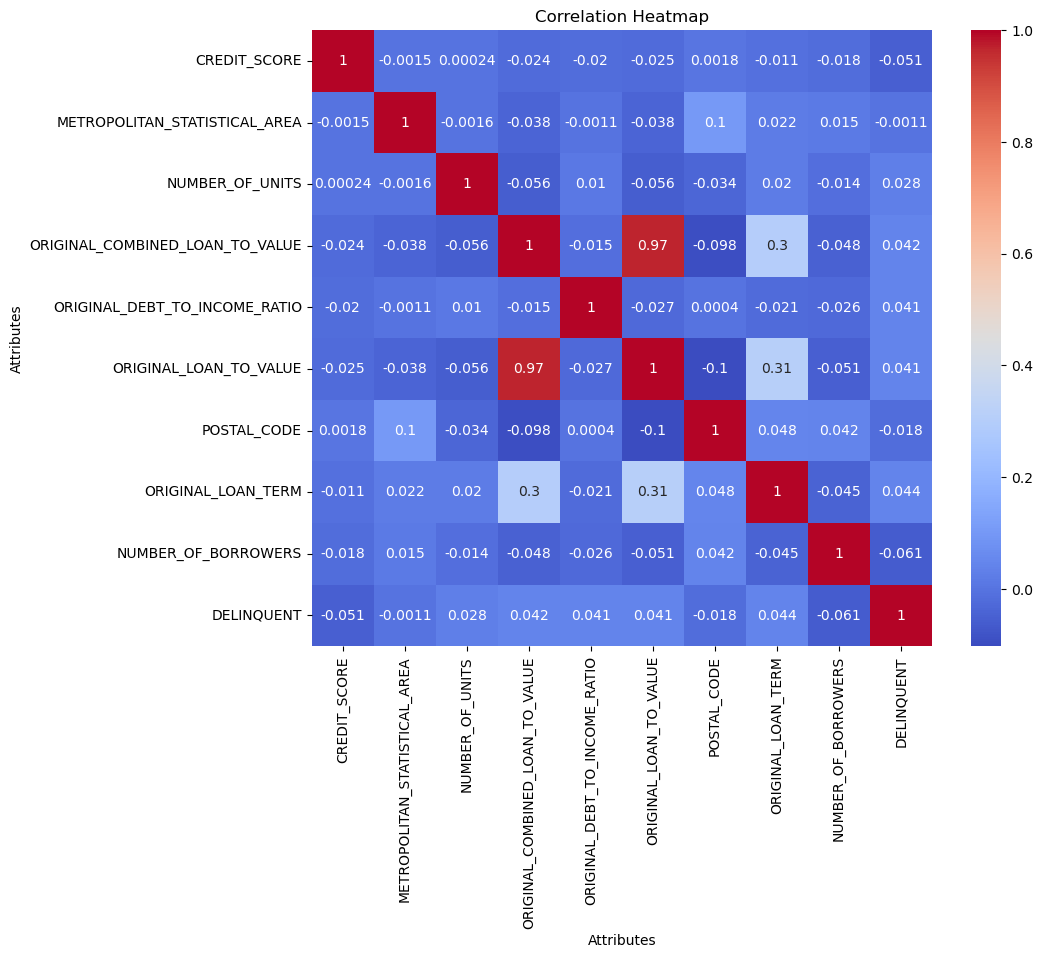

In [23]:
# Calculate the correlation matrix
correlation_matrix = pandas_df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))  # Set the size of the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Add labels and title
plt.xlabel('Attributes')
plt.ylabel('Attributes')
plt.title('Correlation Heatmap')

# Display the heatmap
plt.show()

In [24]:
correlation_matrix

,CREDIT_SCORE,METROPOLITAN_STATISTICAL_AREA,NUMBER_OF_UNITS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_LOAN_TO_VALUE,POSTAL_CODE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,DELINQUENT
CREDIT_SCORE,1.000000,-0.001478,0.000240,-0.024493,-0.020127,-0.024609,0.001773,-0.010523,-0.017925,-0.051411
METROPOLITAN_STATISTICAL_AREA,-0.001478,1.000000,-0.001594,-0.037857,-0.001052,-0.038465,0.102163,0.021899,0.015493,-0.001086
NUMBER_OF_UNITS,0.000240,-0.001594,1.000000,-0.056034,0.010431,-0.056040,-0.034167,0.019635,-0.013771,0.027799
ORIGINAL_COMBINED_LOAN_TO_VALUE,-0.024493,-0.037857,-0.056034,1.000000,-0.015218,0.966293,-0.097923,0.300067,-0.047727,0.041719
ORIGINAL_DEBT_TO_INCOME_RATIO,-0.020127,-0.001052,0.010431,-0.015218,1.000000,-0.027411,0.000396,-0.021348,-0.025733,0.040536
ORIGINAL_LOAN_TO_VALUE,-0.024609,-0.038465,-0.056040,0.966293,-0.027411,1.000000,-0.102370,0.308095,-0.050920,0.041448
POSTAL_CODE,0.001773,0.102163,-0.034167,-0.097923,0.000396,-0.102370,1.000000,0.048035,0.042449,-0.017879
ORIGINAL_LOAN_TERM,-0.010523,0.021899,0.019635,0.300067,-0.021348,0.308095,0.048035,1.000000,-0.044623,0.043527
NUMBER_OF_BORROWERS,-0.017925,0.015493,-0.013771,-0.047727,-0.025733,-0.050920,0.042449,-0.044623,1.000000,-0.060796
DELINQUENT,-0.051411,-0.001086,0.027799,0.041719,0.040536,0.041448,-0.017879,0.043527,-0.060796,1.000000


### Explore CREDIT_SCORE

In [25]:
# A credit score is unavailable when its value is 9999.
print('The number of loan records with unavailable credit scores:', df.filter(df['CREDIT_SCORE'] == 9999).count())

The number of loan records with unavailable credit scores: 40


In [26]:
# Replace the values of unavailable credit scores with None.
df = df.withColumn('CREDIT_SCORE', when(df['CREDIT_SCORE'] != 9999, df['CREDIT_SCORE']).otherwise(None))

Number of missing values: 40

Descriptive statistics:

count    149957.000000
mean        751.404129
std          44.257013
min         479.000000
25%         722.000000
50%         760.000000
75%         787.000000
max         839.000000
Name: CREDIT_SCORE, dtype: float64


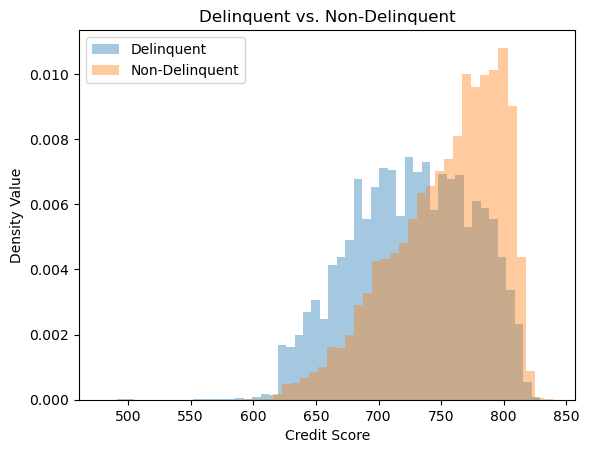

In [27]:
# Analyse the CREDIT_SCORE column.

pandasDF = df.select(df['CREDIT_SCORE'], df['DELINQUENT']).toPandas()
analyseContinuousData(pandasDF, column='CREDIT_SCORE', xlabel='Credit Score')

In [28]:
# Replace the values of unavailable credit scores with 0.
df = df.withColumn('CREDIT_SCORE', when(df['CREDIT_SCORE'].isNotNull(), df['CREDIT_SCORE']).otherwise(0.0))
print('The number of loan records with unavailable credit scores:', df.filter(df['CREDIT_SCORE'] == 0.0).count())

The number of loan records with unavailable credit scores: 40


Explore First Time Homebuyer Flag

In [29]:
# A first-time homebuyer flag is unavailable when its value is '9'.

print('The number of loan records with unavailable first-time homebuyer flags:', df.filter(df['FIRST_TIME_HOMEBUYER_FLAG'] == '9').count())

The number of loan records with unavailable first-time homebuyer flags: 0


Number of unique values: 2

Number of missing values: 0

N    79.31
Y    20.69
Name: FIRST_TIME_HOMEBUYER_FLAG, dtype: float64


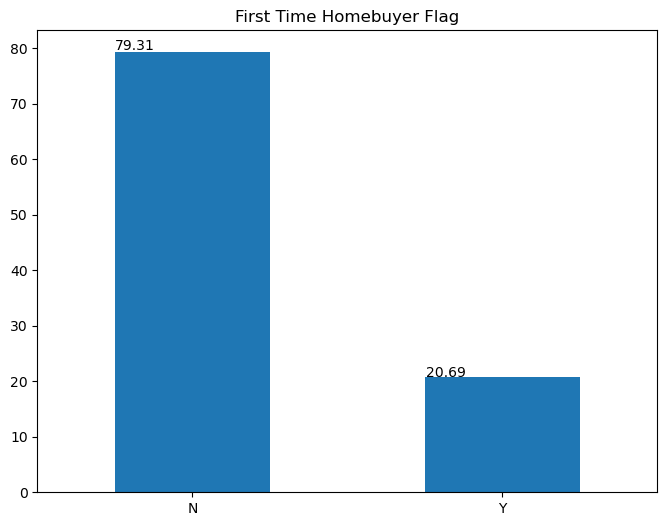

DELINQUENT,0,1
FIRST_TIME_HOMEBUYER_FLAG,,
N,0.905839,0.094161
Y,0.883081,0.116919


In [30]:
# Analyse the FIRST_TIME_HOMEBUYER_FLAG column.

pandasDF = df.select(df['FIRST_TIME_HOMEBUYER_FLAG'], df['DELINQUENT']).toPandas()
analyseCategoricalData(
    pandasDF,
    column='FIRST_TIME_HOMEBUYER_FLAG',
    fig_size=(8, 6),
    title='First Time Homebuyer Flag',
    rot=0
)
pd.crosstab(pandasDF.FIRST_TIME_HOMEBUYER_FLAG, pandasDF.DELINQUENT, normalize='index')

### Explore METROPOLITAN_STATISTICAL_AREA


In [31]:
# MSA is codes that corresponds to a certain area and have some information about them
print('Number of unique MSA codes:', df.select(df['METROPOLITAN_STATISTICAL_AREA']).distinct().count())
print('Number of loan records with unavailable MSA codes:', df.filter(df['METROPOLITAN_STATISTICAL_AREA'].isNull()).count())

Number of unique MSA codes: 415
Number of loan records with unavailable MSA codes: 13731


replace null with 0 and keep non null as usuall


In [32]:
df = df.withColumn('METROPOLITAN_STATISTICAL_AREA', when(df['METROPOLITAN_STATISTICAL_AREA'].isNotNull(), df['METROPOLITAN_STATISTICAL_AREA']).otherwise(0.0))

Number of missing values: 0

Descriptive statistics:

count    149997.000000
mean      27475.255665
std       13819.249616
min           0.000000
25%       16984.000000
50%       29820.000000
75%       38900.000000
max       49740.000000
Name: METROPOLITAN_STATISTICAL_AREA, dtype: float64


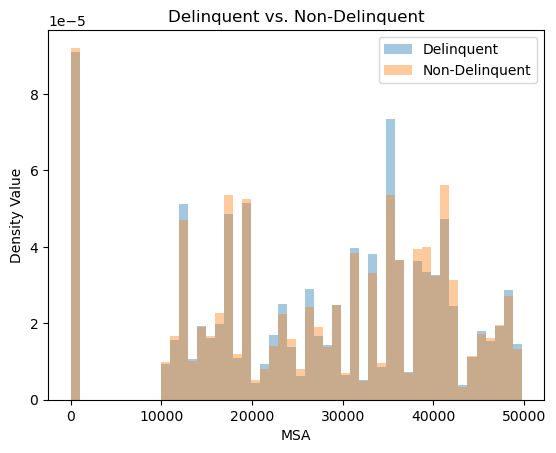

DELINQUENT,0,1
METROPOLITAN_STATISTICAL_AREA,,
39140.0,0.666667,0.333333
12980.0,0.741935,0.258065
29340.0,0.768116,0.231884
36220.0,0.775000,0.225000
33124.0,0.777333,0.222667


In [33]:
pandasDF = df.select(df['METROPOLITAN_STATISTICAL_AREA'], df['DELINQUENT']).toPandas()
analyseContinuousData(pandasDF, column='METROPOLITAN_STATISTICAL_AREA', xlabel='MSA')
pd.crosstab(pandasDF.METROPOLITAN_STATISTICAL_AREA, pandasDF.DELINQUENT, normalize='index').sort_values(by=1, ascending=False).head()

### Explore NUMBER_OF_UNITS

In [34]:
# The number of units is unavailable when its value is 99.

print('The number of loan records with the unavailable number of units:', df.filter(df['NUMBER_OF_UNITS'] == 99).count())

The number of loan records with the unavailable number of units: 0


Number of unique values: 4

Number of missing values: 0

1.0    97.96
2.0     1.46
3.0     0.33
4.0     0.26
Name: NUMBER_OF_UNITS, dtype: float64


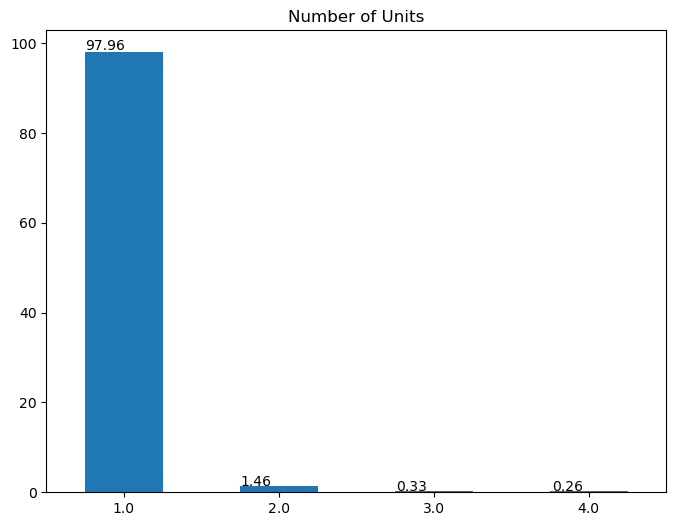

DELINQUENT,0,1
NUMBER_OF_UNITS,,
3.0,0.806452,0.193548
2.0,0.842419,0.157581
4.0,0.852332,0.147668
1.0,0.902451,0.097549


In [35]:
# Analyse the NUMBER_OF_UNITS column.

pandasDF = df.select(df['NUMBER_OF_UNITS'], df['DELINQUENT']).toPandas()
analyseCategoricalData(
    pandasDF,
    column='NUMBER_OF_UNITS',
    fig_size=(8, 6),
    title='Number of Units',
    rot=0
)
pd.crosstab(pandasDF.NUMBER_OF_UNITS, pandasDF.DELINQUENT, normalize='index').sort_values(by=1, ascending=False)

### Explore OCCUPANCY_STATUS

In [36]:
# An occupancy status is unavailable when its value is '9'.

print('The number of loan records with unavailable occupancy status:', df.filter(df['OCCUPANCY_STATUS'] == '9').count())

The number of loan records with unavailable occupancy status: 0


Number of unique values: 3

Number of missing values: 0

P    89.57
I     6.50
S     3.93
Name: OCCUPANCY_STATUS, dtype: float64


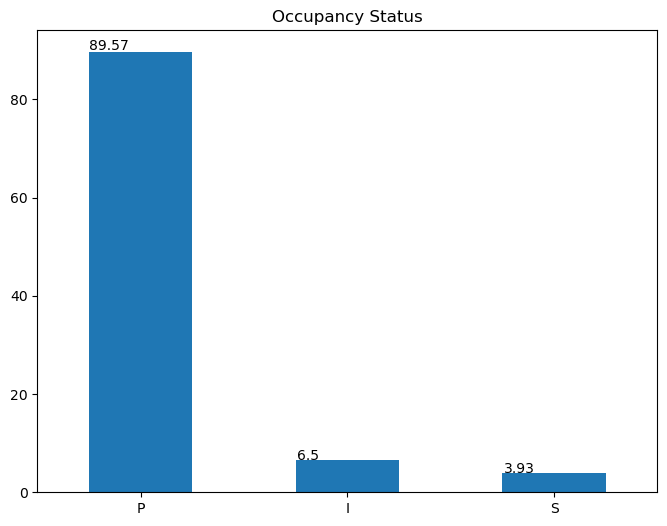

DELINQUENT,0,1
OCCUPANCY_STATUS,,
I,0.872653,0.127347
P,0.902540,0.097460
S,0.916102,0.083898


In [37]:
# Analyse the OCCUPANCY_STATUS column.

pandasDF = df.select(df['OCCUPANCY_STATUS'], df['DELINQUENT']).toPandas()
analyseCategoricalData(
    pandasDF,
    column='OCCUPANCY_STATUS',
    fig_size=(8, 6),
    title='Occupancy Status',
    rot=0
)
pd.crosstab(pandasDF.OCCUPANCY_STATUS, pandasDF.DELINQUENT, normalize='index').sort_values(by=1, ascending=False)

### Explore ORIGINAL_COMBINED_LOAN_TO_VALUE of property


In [38]:
# An original combined LTV is unavailable when its value is 999.

print('The number of loan records with unavailable original combined LTVs:', df.filter(df['ORIGINAL_COMBINED_LOAN_TO_VALUE'] == 999).count())

The number of loan records with unavailable original combined LTVs: 4


In [39]:
# Replace unavailable values with None for the EDA

df = df.withColumn('ORIGINAL_COMBINED_LOAN_TO_VALUE', when(df['ORIGINAL_COMBINED_LOAN_TO_VALUE'] != 999, df['ORIGINAL_COMBINED_LOAN_TO_VALUE']).otherwise(None))

Number of missing values: 4

Descriptive statistics:

count    149993.000000
mean         74.403279
std          17.160681
min           5.000000
25%          66.000000
50%          79.000000
75%          87.000000
max         190.000000
Name: ORIGINAL_COMBINED_LOAN_TO_VALUE, dtype: float64


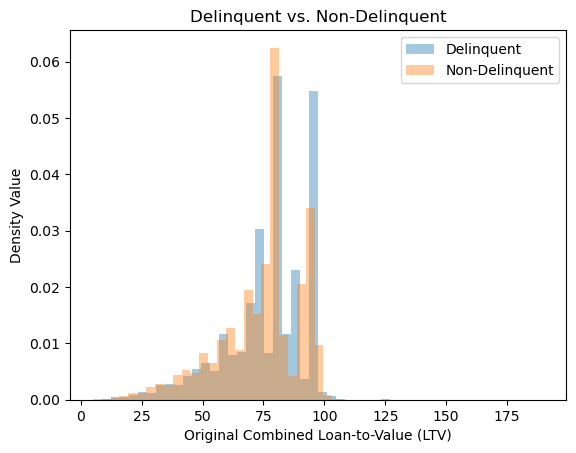

In [40]:
# Analyse the ORIGINAL_COMBINED_LOAN_TO_VALUE column.

pandasDF = df.select(df['ORIGINAL_COMBINED_LOAN_TO_VALUE'], df['DELINQUENT']).toPandas()
analyseContinuousData(pandasDF, column='ORIGINAL_COMBINED_LOAN_TO_VALUE', xlabel='Original Combined Loan-to-Value (LTV)')

In [41]:
# Replace the missing values with the median for training

df = df.withColumn('ORIGINAL_COMBINED_LOAN_TO_VALUE', when(df['ORIGINAL_COMBINED_LOAN_TO_VALUE'].isNotNull(), df['ORIGINAL_COMBINED_LOAN_TO_VALUE']).otherwise(80))

### Explore ORIGINAL_DEBT_TO_INCOME_RATIO

In [42]:
# An original combined LTV is unavailable when its value is 999.

print('The number of loan records with unavailable original DTIR:', df.filter(df['ORIGINAL_DEBT_TO_INCOME_RATIO'] == 999).count())

The number of loan records with unavailable original DTIR: 604


In [43]:
# Replace unavailable values with None.

df = df \
.withColumn('ORIGINAL_DEBT_TO_INCOME_RATIO', when(df['ORIGINAL_DEBT_TO_INCOME_RATIO'] != 999, df['ORIGINAL_DEBT_TO_INCOME_RATIO']).otherwise(None))

Number of missing values: 604

Descriptive statistics:

count    149393.000000
mean         34.776810
std           9.594201
min           1.000000
25%          28.000000
50%          36.000000
75%          43.000000
max          50.000000
Name: ORIGINAL_DEBT_TO_INCOME_RATIO, dtype: float64


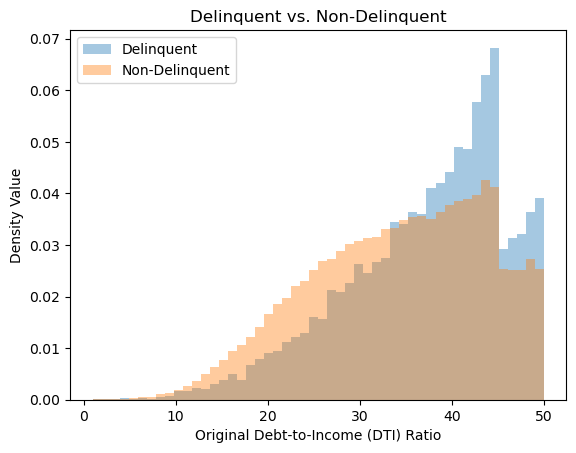

In [44]:
# Analyse the ORIGINAL_DEBT_TO_INCOME_RATIO column.

pandasDF = df.select(df['ORIGINAL_DEBT_TO_INCOME_RATIO'], df['DELINQUENT']).toPandas()
analyseContinuousData(pandasDF, column='ORIGINAL_DEBT_TO_INCOME_RATIO', xlabel='Original Debt-to-Income (DTI) Ratio')

In [45]:
# Replace unavailable values with 999 to check the density values

df = df \
.withColumn('ORIGINAL_DEBT_TO_INCOME_RATIO', when(df['ORIGINAL_DEBT_TO_INCOME_RATIO'].isNotNull(), df['ORIGINAL_DEBT_TO_INCOME_RATIO']).otherwise(999))

In [46]:
# Create a new colomn named HIGH_ORIGINAL_DEBT_TO_INCOME_RATIO so it will not mix

df = df.withColumn('HIGH_ORIGINAL_DEBT_TO_INCOME_RATIO', when(df['ORIGINAL_DEBT_TO_INCOME_RATIO'].isNull(), 1.0).otherwise(0.0))

In [47]:
# Analyse the HIGH_ORIGINAL_DEBT_TO_INCOME_RATIO colomn.

pandasDF = df.select(df['HIGH_ORIGINAL_DEBT_TO_INCOME_RATIO'], df['DELINQUENT']).toPandas()
pd.crosstab(pandasDF.HIGH_ORIGINAL_DEBT_TO_INCOME_RATIO, pandasDF.DELINQUENT, normalize='index')

DELINQUENT,0,1
HIGH_ORIGINAL_DEBT_TO_INCOME_RATIO,,
0.0,0.901131,0.098869


### Explore ORIGINAL_LOAN_TO_VALUE of the property

In [48]:
# An original LTV is unavailable when its value is 999.

print('The number of loan records with unavailable original LTVs:', df.filter(df['ORIGINAL_LOAN_TO_VALUE'] == 999).count())

The number of loan records with unavailable original LTVs: 1


In [49]:
# Replace unavailable values with None.

df = df.withColumn('ORIGINAL_LOAN_TO_VALUE', when(df['ORIGINAL_LOAN_TO_VALUE'] != 999, df['ORIGINAL_LOAN_TO_VALUE']).otherwise(None))

Number of missing values: 1

Descriptive statistics:

count    149996.000000
mean         74.179605
std          17.174335
min           5.000000
25%          65.000000
50%          79.000000
75%          86.000000
max         190.000000
Name: ORIGINAL_LOAN_TO_VALUE, dtype: float64


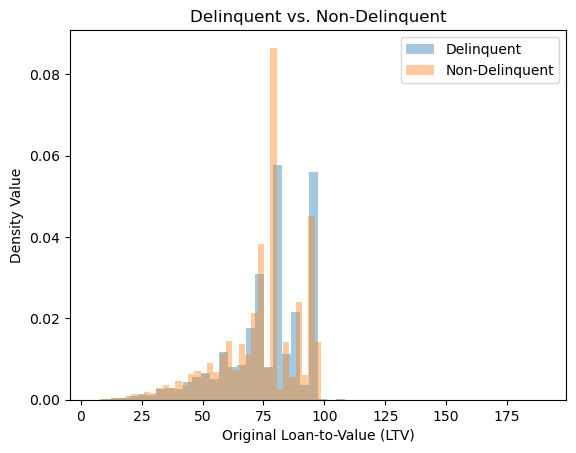

In [50]:
# Analyse the ORIGINAL_LOAN_TO_VALUE column.

pandasDF = df.select(df['ORIGINAL_LOAN_TO_VALUE'], df['DELINQUENT']).toPandas()
analyseContinuousData(pandasDF, column='ORIGINAL_LOAN_TO_VALUE', xlabel='Original Loan-to-Value (LTV)')

In [51]:
# Replace  the missing values with the median.

df = df.withColumn('ORIGINAL_LOAN_TO_VALUE', when(df['ORIGINAL_LOAN_TO_VALUE'].isNotNull(), df['ORIGINAL_LOAN_TO_VALUE']).otherwise(80))

### Explore CHANNEL

Number of unique values: 3

Number of missing values: 0

R    55.62
C    32.62
B    11.76
Name: CHANNEL, dtype: float64


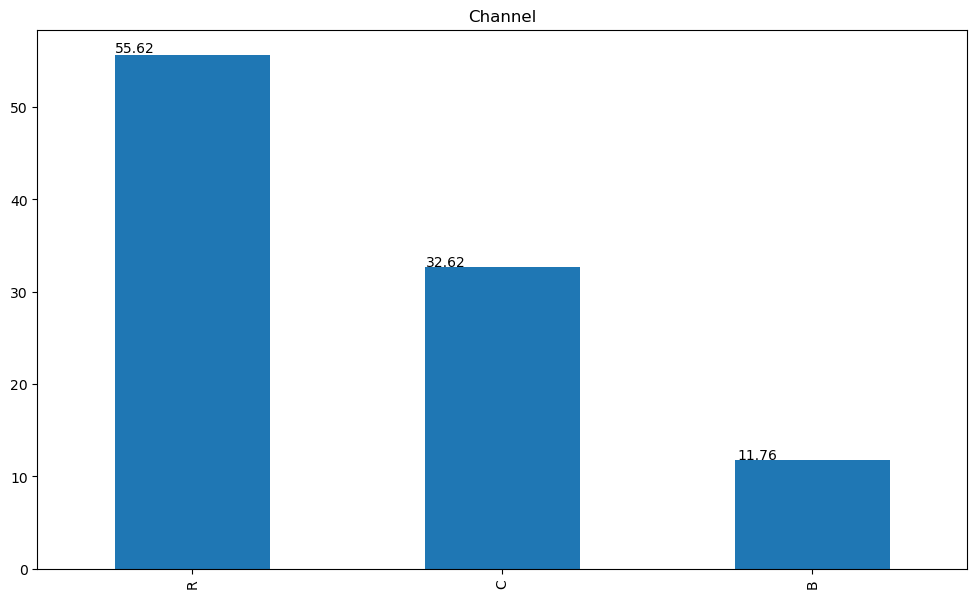

DELINQUENT,0,1
CHANNEL,,
C,0.891816,0.108184
B,0.894254,0.105746
R,0.908049,0.091951


In [52]:
# Analyse the CHANNEL column. 
#Retail - R 
# C Online
# B Broker
pandasDF = df.select(df['CHANNEL'], df['DELINQUENT']).toPandas()
analyseCategoricalData(pandasDF, column='CHANNEL', title='Channel')
pd.crosstab(pandasDF.CHANNEL, pandasDF.DELINQUENT, normalize='index').sort_values(by=1, ascending=False)

### Explore PROPERTY_TYPE

SF = Single Family
CO Condomonium
MH Manufactured Housing
CP: Commercial Property
PU: Planned Unit Development

Number of unique values: 5

Number of missing values: 0

SF    62.90
PU    28.34
CO     8.22
MH     0.38
CP     0.16
Name: PROPERTY_TYPE, dtype: float64


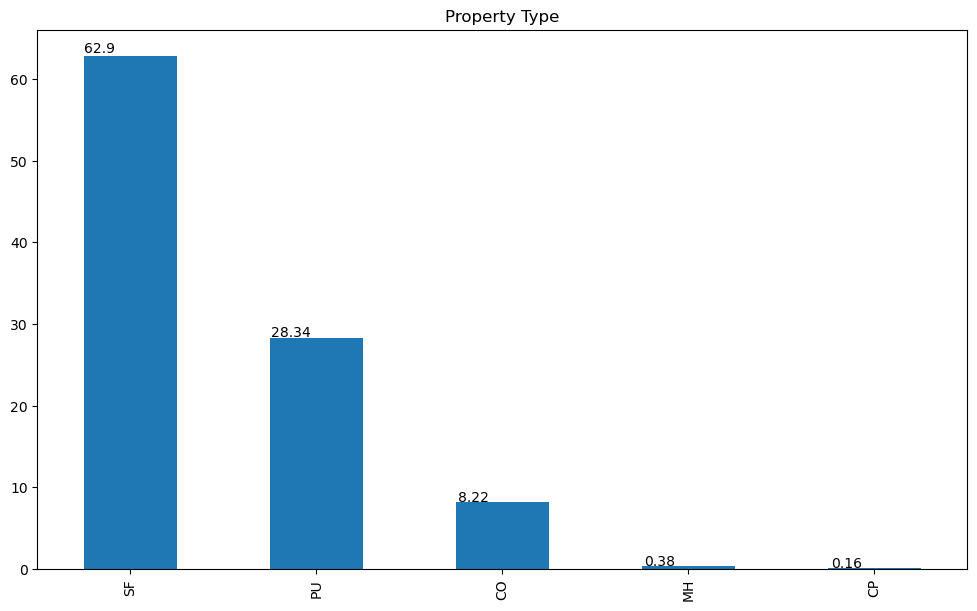

DELINQUENT,0,1
PROPERTY_TYPE,,
MH,0.826011,0.173989
SF,0.898045,0.101955
CO,0.898679,0.101321
PU,0.909606,0.090394
CP,0.918455,0.081545


In [53]:
# Analyse the PROPERTY_TYPE #SIngle Family,.

pandasDF = df.select(df['PROPERTY_TYPE'], df['DELINQUENT']).toPandas()
analyseCategoricalData(pandasDF, column='PROPERTY_TYPE',title='Property Type')
pd.crosstab(pandasDF.PROPERTY_TYPE, pandasDF.DELINQUENT, normalize='index').sort_values(by=1, ascending=False)

### Explore POSTAL_CODE

In [54]:
print('Number of loan records with unavailable postal codes:', df.filter(df['POSTAL_CODE'].isNull()).count())

Number of loan records with unavailable postal codes: 0


### Explore LOAN_PURPOSE

Number of unique values: 3

Number of missing values: 0

P    51.02
N    28.85
C    20.14
Name: LOAN_PURPOSE, dtype: float64


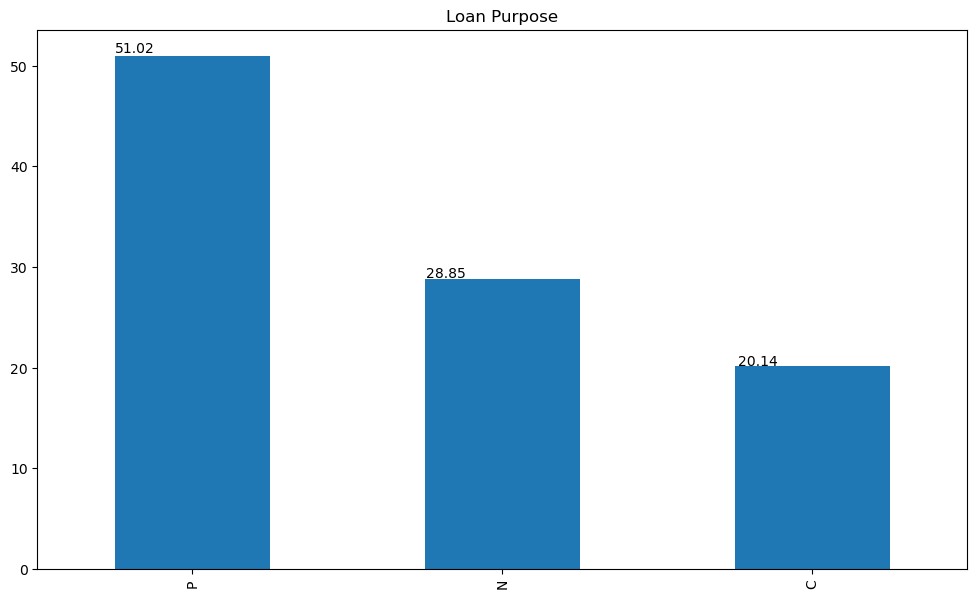

DELINQUENT,0,1
LOAN_PURPOSE,,
C,0.888488,0.111512
P,0.893956,0.106044
N,0.922647,0.077353


In [55]:
# Analyse the LOAN_PURPOSE column
# C = Purchase
# P = Refinance
# N Not avaiable
pandasDF = df.select(df['LOAN_PURPOSE'], df['DELINQUENT']).toPandas()
analyseCategoricalData(pandasDF, column='LOAN_PURPOSE',title='Loan Purpose')
pd.crosstab(pandasDF.LOAN_PURPOSE, pandasDF.DELINQUENT, normalize='index').sort_values(by=1, ascending=False)

### Explore ORIGINAL_LOAN_TERM

Number of missing values: 1

Descriptive statistics:

count    149996.000000
mean        327.901357
std          66.643178
min          96.000000
25%         360.000000
50%         360.000000
75%         360.000000
max         360.000000
Name: ORIGINAL_LOAN_TERM, dtype: float64


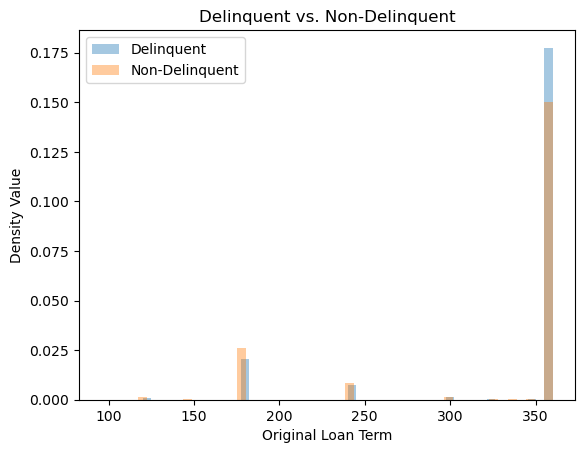

In [56]:
# Analyse the ORIGINAL_LOAN_TERM column (Months).

pandasDF = df.select(df['ORIGINAL_LOAN_TERM'], df['DELINQUENT']).toPandas()
analyseContinuousData(pandasDF, column='ORIGINAL_LOAN_TERM',xlabel='Original Loan Term')


In [57]:
# Replace mIssing with mean of 327
df = df.withColumn('ORIGINAL_LOAN_TERM', when(df['ORIGINAL_LOAN_TERM'].isNotNull(), df['ORIGINAL_LOAN_TERM']).otherwise(327))

### Explore NUMBER_OF_BORROWERS

In [58]:
# The number of borrowers is unavailable when its value is 99.

print('The number of loan records with unavailable borrower numbers:', df.filter(df['NUMBER_OF_BORROWERS'] == 99).count())

The number of loan records with unavailable borrower numbers: 0


In [59]:
df.select(df['NUMBER_OF_BORROWERS']).distinct().show()

+-------------------+
|NUMBER_OF_BORROWERS|
+-------------------+
|                1.0|
|                4.0|
|                3.0|
|                2.0|
|                5.0|
+-------------------+



In [60]:
# Cast its data type to StringType.

df = df.withColumn('NUMBER_OF_BORROWERS', df['NUMBER_OF_BORROWERS'].cast(StringType()))

Number of unique values: 5

Number of missing values: 0

1.0    52.94
2.0    46.28
3.0     0.68
4.0     0.11
5.0     0.00
Name: NUMBER_OF_BORROWERS, dtype: float64


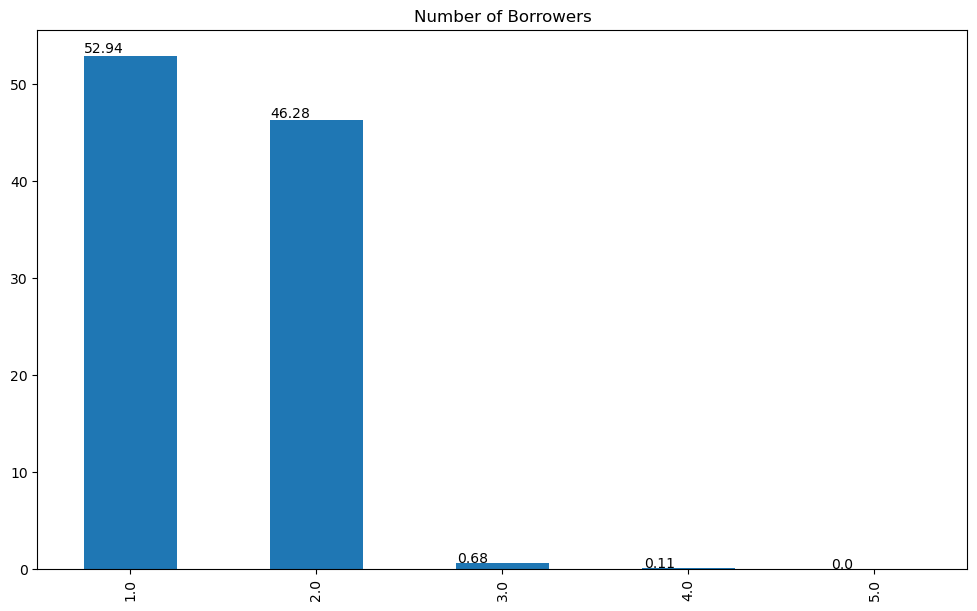

DELINQUENT,0,1
NUMBER_OF_BORROWERS,,
3.0,0.854492,0.145508
4.0,0.860759,0.139241
1.0,0.882572,0.117428
2.0,0.923140,0.076860
5.0,1.000000,0.000000


In [61]:
# Analyse the NUMBER_OF_BORROWERS column.

pandasDF = df.select(df['NUMBER_OF_BORROWERS'], df['DELINQUENT']).toPandas()
analyseCategoricalData(pandasDF, column='NUMBER_OF_BORROWERS',title='Number of Borrowers')
pd.crosstab(pandasDF.NUMBER_OF_BORROWERS, pandasDF.DELINQUENT, normalize='index').sort_values(by=1, ascending=False)

In [62]:
# Cast its data type back to DoubleType.

df = df.withColumn('NUMBER_OF_BORROWERS', df['NUMBER_OF_BORROWERS'].cast(DoubleType()))

##  EDA done


In [63]:
df.printSchema()

root
 |-- CREDIT_SCORE: double (nullable = true)
 |-- FIRST_TIME_HOMEBUYER_FLAG: string (nullable = true)
 |-- METROPOLITAN_STATISTICAL_AREA: double (nullable = true)
 |-- NUMBER_OF_UNITS: double (nullable = true)
 |-- OCCUPANCY_STATUS: string (nullable = true)
 |-- ORIGINAL_COMBINED_LOAN_TO_VALUE: double (nullable = true)
 |-- ORIGINAL_DEBT_TO_INCOME_RATIO: double (nullable = true)
 |-- ORIGINAL_LOAN_TO_VALUE: double (nullable = true)
 |-- CHANNEL: string (nullable = true)
 |-- PROPERTY_TYPE: string (nullable = true)
 |-- POSTAL_CODE: double (nullable = true)
 |-- LOAN_PURPOSE: string (nullable = true)
 |-- ORIGINAL_LOAN_TERM: double (nullable = true)
 |-- NUMBER_OF_BORROWERS: double (nullable = true)
 |-- DELINQUENT: long (nullable = true)
 |-- HIGH_ORIGINAL_DEBT_TO_INCOME_RATIO: double (nullable = false)



Check amount of Denlinquents and Non Delinquents, OverSampling

In [64]:
df.count()

149997